In [46]:
import pandas as pd
from sklearn.mixture import GaussianMixture

df = pd.read_csv("dataset.csv", index_col=0)
df.rename(columns={'Real': 'Prediction', '40':'SpoofType', '41':'Illumination', '42':'Environment', '43':'Spoof'}, inplace=True)
# the prediction by silent face takes values 0-2. Gotta convert it.
df['Prediction'] = df['Prediction'].replace({0.0: 1, 1.0: 0, 2.0: 1})
df['Prediction'] = df['Prediction'].astype(int)

embeddings = pd.read_csv('dropout_embeddings.csv', index_col=0)

df = df.drop_duplicates()
common_index = df.index.intersection(embeddings.index)
df = df.loc[common_index]
embeddings = embeddings.loc[common_index]

pd.testing.assert_series_equal(df.index.to_series(), embeddings.index.to_series())


gmm = GaussianMixture(n_components=5, random_state=42)
clusters = gmm.fit_predict(embeddings)


# embeddings = pd.get_dummies(embeddings, columns=['Cluster'], dtype=int)

In [65]:
embeddings['Spoof'] = df['Spoof']
embeddings['Cluster'] = clusters
embeddings['Illumination'] = df['Illumination']

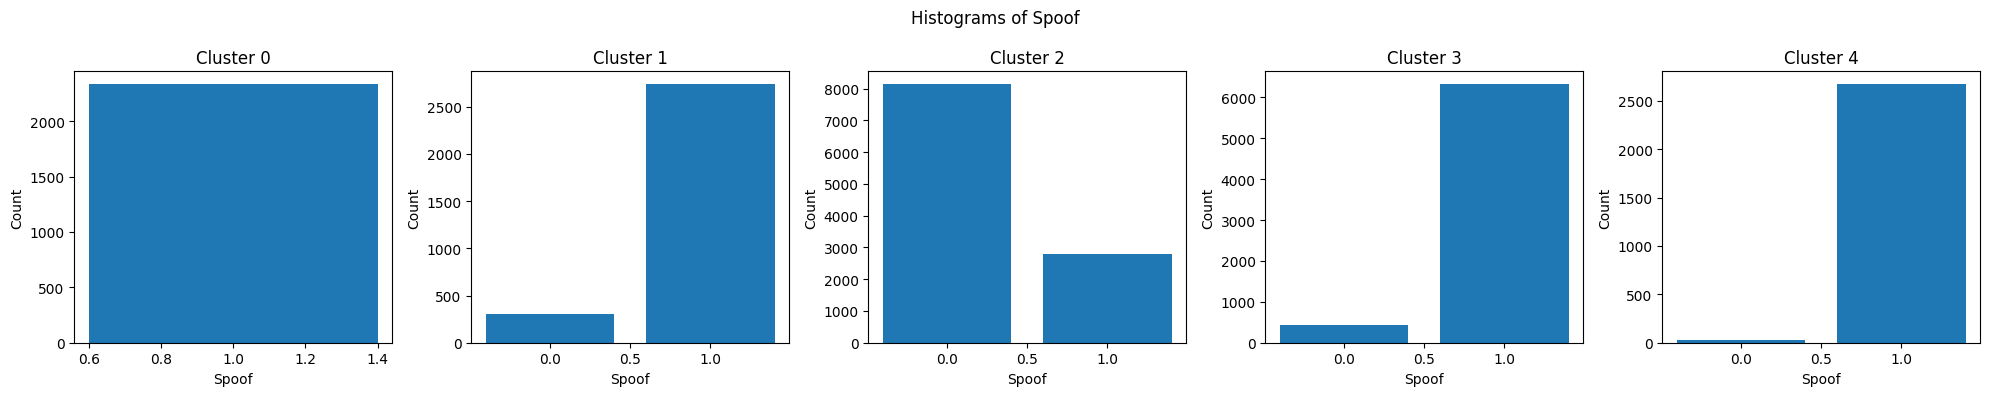

In [47]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))

# Create a histogram for each cluster
for cluster_id, group in embeddings.groupby('Cluster'):
    # Count the frequency of each value of the current feature in the current cluster
    counts = group["Spoof"].value_counts()

    # Create a bar chart of the counts in the current subplot
    axs[cluster_id].bar(counts.index, counts.values)
    axs[cluster_id].set_xlabel("Spoof")
    axs[cluster_id].set_ylabel("Count")
    axs[cluster_id].set_title(f"Cluster {cluster_id}")

# Add a title to the overall plot
plt.suptitle("Histograms of Spoof")

# Adjust the layout of the subplots
plt.tight_layout()

# Display the overall plot
plt.show()

In [66]:
embeddings.head()

,1,2,3,4,5,6,7,8,9,10,...,122,123,124,125,126,127,128,Spoof,Cluster,Illumination
Data/test/6964/spoof/494405.png,0.420929,0.391198,0.395073,-0.421826,0.368112,0.353278,0.749079,0.455125,-0.878119,-0.339846,...,0.688752,-0.765734,-0.755238,0.726697,-0.765685,-0.470916,0.775886,1,2,2
Data/test/6407/spoof/494411.png,-0.147611,0.357509,-0.029671,-0.238791,0.286075,-0.134124,0.624391,0.178886,-0.596819,-0.246836,...,0.680034,-0.574118,-0.704340,0.688574,-0.656510,0.135470,0.686906,1,2,1
Data/test/6153/spoof/494412.png,-0.105897,-0.249867,-0.077944,0.181672,-0.120957,-0.085050,0.615739,-0.094033,-0.588235,0.141131,...,0.588970,-0.605586,-0.580930,0.522196,-0.592422,0.108543,0.643653,1,2,1
Data/test/6411/live/494418.png,0.441198,0.528195,0.404773,-0.509041,0.446964,0.322769,0.645940,0.537904,-0.691915,-0.460678,...,0.608733,-0.600595,-0.675778,0.649979,-0.616289,-0.460027,0.677907,0,2,0
Data/test/6336/spoof/494419.png,0.753356,0.419226,0.744619,-0.425761,0.417521,0.629097,0.054008,0.498429,-0.053692,-0.445463,...,0.013625,-0.103442,0.036649,0.001247,-0.089932,-0.705690,0.065030,1,0,1


In [110]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

sf_column = {'Spoof':128, 'Cluster':129, 'Illumination':130}

class EmbeddingsDataset(Dataset):
    def __init__(self, embeddings):
        self.embeddings = embeddings

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        embedding = torch.tensor(self.embeddings.iloc[idx, :128].values, dtype=torch.float32)
        spoof = torch.tensor(self.embeddings.iloc[idx, 128], dtype=torch.long)
        # 128 = Spoof, 129 = Cluster, 130 = Illumination
        domain = torch.tensor(self.embeddings.iloc[idx, 129], dtype=torch.long)
        return embedding, spoof, domain


class AdversarialModel(nn.Module):
    def __init__(self, num_clusters):
        super(AdversarialModel, self).__init__()
        self.step = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )

        self.anti_spoofing_head = nn.Sequential(
            nn.Linear(64, 2)
        )

        self.domain_head = nn.Sequential(
            nn.Linear(64, num_clusters)
        )

    def forward(self, x):
        x = self.step(x)
        anti_spoofing_logits = self.anti_spoofing_head(x)
        domain_logits = self.domain_head(x)
        return anti_spoofing_logits, domain_logits

In [103]:
from sklearn.model_selection import train_test_split

num_epochs = 3
learning_rate = 0.001
batch_size = 64


train_embeddings, test_embeddings = train_test_split(embeddings, test_size=0.2, random_state=42)


train_dataset = EmbeddingsDataset(train_embeddings)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = EmbeddingsDataset(test_embeddings)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AdversarialModel(2).to(device)


criterion = nn.CrossEntropyLoss()
optimizer_classifier = optim.Adam(model.anti_spoofing_head.parameters(), lr=learning_rate)
optimizer_domain = optim.Adam(model.domain_head.parameters(), lr=learning_rate)


target_domain = 0

for epoch in range(num_epochs):
    for i, (embedding, spoof, domain) in enumerate(train_loader):
        # Move the data to the device
        embedding = embedding.to(device)
        spoof = spoof.to(device)
        domain = (domain == target_domain).long().to(device)



        # Step 1: Update all weights except the domain head
        optimizer_classifier.zero_grad()

        anti_spoofing_logits, domain_logits = model(embedding)
        loss_main = criterion(anti_spoofing_logits, spoof) - criterion(domain_logits, domain)
        loss_main.backward()
        optimizer_classifier.step()

        # Step 2: Update the domain head
        optimizer_domain.zero_grad()

        _, domain_logits = model(embedding)
        loss_domain = criterion(domain_logits, domain)
        loss_domain.backward()
        optimizer_domain.step()

        # Print progress
        if (i+1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(data_loader)}], Loss_main: {loss_main.item()}, Loss_domain: {loss_domain.item()}")

print("Training complete.")

Epoch [1/3], Step [50/403], Loss_main: -0.004761040210723877, Loss_domain: 0.6657522320747375
Epoch [1/3], Step [100/403], Loss_main: -0.006015121936798096, Loss_domain: 0.6299014091491699
Epoch [1/3], Step [150/403], Loss_main: -0.007017672061920166, Loss_domain: 0.5696182250976562
Epoch [1/3], Step [200/403], Loss_main: -0.0065149664878845215, Loss_domain: 0.5178641676902771
Epoch [1/3], Step [250/403], Loss_main: -0.0009778738021850586, Loss_domain: 0.6109321713447571
Epoch [1/3], Step [300/403], Loss_main: -0.0045957863330841064, Loss_domain: 0.4940187931060791
Epoch [2/3], Step [50/403], Loss_main: -0.003193408250808716, Loss_domain: 0.4571388363838196
Epoch [2/3], Step [100/403], Loss_main: -0.0026853084564208984, Loss_domain: 0.5048352479934692
Epoch [2/3], Step [150/403], Loss_main: -0.0017455220222473145, Loss_domain: 0.49129676818847656
Epoch [2/3], Step [200/403], Loss_main: -0.0027265548706054688, Loss_domain: 0.47062504291534424
Epoch [2/3], Step [250/403], Loss_main: -0.0

In [129]:
from sklearn.model_selection import KFold
from torch.utils.data.sampler import SubsetRandomSampler

sf_column = {'Spoof':128, 'Cluster':129, 'Illumination':130}

def train(target_domain = 0, sensitive_feature = "Spoof"):

    num_folds = 5
    num_epochs = 3
    
    class EmbeddingsDataset(Dataset):
        def __init__(self, embeddings):
            self.embeddings = embeddings

        def __len__(self):
            return len(self.embeddings)

        def __getitem__(self, idx):
            embedding = torch.tensor(self.embeddings.iloc[idx, :128].values, dtype=torch.float32)
            spoof = torch.tensor(self.embeddings.iloc[idx, 128], dtype=torch.long)
            # 128 = Spoof, 129 = Cluster, 130 = Illumination
            domain = torch.tensor(self.embeddings.iloc[idx, sf_column[sensitive_feature]], dtype=torch.long)
            return embedding, spoof, domain


    # Create the dataset
    dataset = EmbeddingsDataset(embeddings)

    # Create the KFold object
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    # Iterate over the folds
    for fold, (train_indices, test_indices) in enumerate(kf.split(dataset)):
        print(f"Sensitive Feature: {sensitive_feature}, Domain: {td}, Fold {fold+1}")

        # Create the data loaders for the current fold
        train_sampler = SubsetRandomSampler(train_indices)
        test_sampler = SubsetRandomSampler(test_indices)
        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
        test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

        # Create the model and set the device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = AdversarialModel(2).to(device)

        # Define the loss functions and optimizers
        criterion = nn.CrossEntropyLoss()
        optimizer_classifier = optim.Adam(model.anti_spoofing_head.parameters(), lr=learning_rate)
        optimizer_domain = optim.Adam(model.domain_head.parameters(), lr=learning_rate)

        # Train the model for the current fold
        target_domain = 0
        for epoch in range(num_epochs):
            for i, (embedding, spoof, domain) in enumerate(train_loader):
                # Move the data to the device
                embedding = embedding.to(device)
                spoof = spoof.to(device)
                domain = (domain == target_domain).long().to(device)

                # Step 1: Update all weights except the domain head
                optimizer_classifier.zero_grad()

                anti_spoofing_logits, domain_logits = model(embedding)
                loss_main = criterion(anti_spoofing_logits, spoof) - criterion(domain_logits, domain)
                loss_main.backward()
                optimizer_classifier.step()

                # Step 2: Update the domain head
                optimizer_domain.zero_grad()

                _, domain_logits = model(embedding)
                loss_domain = criterion(domain_logits, domain)
                loss_domain.backward()
                optimizer_domain.step()

                # Print progress
                if (i+1) % 100 == 0:
                    print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss_main: {loss_main.item()}, Loss_domain: {loss_domain.item()}")
        print("Training complete for fold", fold+1)
    
    # Set the model to evaluation mode
    model.eval()

    # Define the lists to store the true and predicted labels
    true_labels = []
    predicted_labels = []

    # Iterate over the test data
    for i, (embedding, spoof, domain) in enumerate(test_loader):

        # Move the data to the device
        embedding = embedding.to(device)
        spoof = spoof.to(device)

        # Forward pass
        anti_spoofing_logits, domain_logits = model(embedding)

        # Get the predicted labels
        _, predicted = torch.max(anti_spoofing_logits, 1)

        # Append the true and predicted labels to the lists
        true_labels += spoof.tolist()
        predicted_labels += predicted.tolist()

    # Calculate the evaluation metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    roc_auc = roc_auc_score(true_labels, predicted_labels)

    metrics = [accuracy, precision, recall, f1, roc_auc]
    return metrics


In [130]:
table = {}
for sf in sf_column:
    for td in embeddings[sf].unique():
        metrics = train(target_domain=td, sensitive_feature=sf)
        name = str(sf) + '_' + str(td)
        table[name] = metrics
table


Sensitive Feature: Spoof, Domain: 1, Fold 1
Epoch [1/3], Step [100/322], Loss_main: 0.003677666187286377, Loss_domain: 0.5597242116928101
Epoch [1/3], Step [200/322], Loss_main: 0.0007641315460205078, Loss_domain: 0.5949178338050842
Epoch [1/3], Step [300/322], Loss_main: 0.002371877431869507, Loss_domain: 0.49965962767601013
Epoch [2/3], Step [100/322], Loss_main: 0.001490563154220581, Loss_domain: 0.4884730577468872
Epoch [2/3], Step [200/322], Loss_main: 0.007254302501678467, Loss_domain: 0.4659276008605957
Epoch [2/3], Step [300/322], Loss_main: 0.004740417003631592, Loss_domain: 0.5337275266647339
Epoch [3/3], Step [100/322], Loss_main: 0.000594794750213623, Loss_domain: 0.37029698491096497
Epoch [3/3], Step [200/322], Loss_main: -0.0020847320556640625, Loss_domain: 0.5119344592094421
Epoch [3/3], Step [300/322], Loss_main: 0.0033956170082092285, Loss_domain: 0.4233514070510864
Training complete for fold 1
Sensitive Feature: Spoof, Domain: 1, Fold 2
Epoch [1/3], Step [100/322], Lo

{'Spoof_1': [0.8134342846049311,
  0.8301531846277882,
  0.903744880046811,
  0.8653873091469394,
  0.7695296818006704],
 'Spoof_0': [0.811687051058047,
  0.8290322580645161,
  0.9022820362785254,
  0.8641075931633511,
  0.7676441918265103],
 'Cluster_2': [0.8138225587264609,
  0.8279541210989597,
  0.9081334113516677,
  0.8661922701269709,
  0.7679732261605423],
 'Cluster_0': [0.8182877111240536,
  0.8409340659340659,
  0.8955529549444119,
  0.867384528194956,
  0.7807251214422002],
 'Cluster_4': [0.8147932440302854,
  0.8276595744680851,
  0.9104739613809245,
  0.8670938980217331,
  0.7682779501076579],
 'Cluster_1': [0.8206173558532324,
  0.8257575757575758,
  0.9248098303101229,
  0.8724813690311897,
  0.769964061144675],
 'Cluster_3': [0.8130460104834013,
  0.8313090418353576,
  0.901111761263897,
  0.8648041555524357,
  0.7702327415667437],
 'Illumination_2': [0.8196466705494079,
  0.8289717155696538,
  0.9174956114686952,
  0.8709901402582975,
  0.7720772921740475],
 'Illuminati

In [131]:
table_df = pd.DataFrame.from_dict(table, orient='index', columns=['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC'])
table_df.to_csv('metrics.csv')

In [108]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Set the model to evaluation mode
model.eval()

# Define the lists to store the true and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test data
for i, (embedding, spoof, domain) in enumerate(test_loader):

    # Move the data to the device
    embedding = embedding.to(device)
    spoof = spoof.to(device)

    # Forward pass
    anti_spoofing_logits, domain_logits = model(embedding)

    # Get the predicted labels
    _, predicted = torch.max(anti_spoofing_logits, 1)

    # Append the true and predicted labels to the lists
    true_labels += spoof.tolist()
    predicted_labels += predicted.tolist()

# Calculate the evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
roc_auc = roc_auc_score(true_labels, predicted_labels)

# Print the evaluation metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')
print(f'Roc Auc score: {roc_auc}')

Accuracy: 0.8167346146379344
Precision: 0.8345051379123851
Recall: 0.9028671737858397
F1 score: 0.8673412029229904
Roc Auc score: 0.7748611691202711
